In [154]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocess
import sys
import progressbar

sys.path.append("Python-ELM")
import elm

from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

%matplotlib inline

In [52]:
#Loading data
A = scio.loadmat("tesis_cami/A.mat")["A"]
b = scio.loadmat("tesis_cami/b.mat")["b"]
XDOM = scio.loadmat("tesis_cami/XDOM.mat")["XDOM"]
YDOM = scio.loadmat("tesis_cami/YDOM.mat")["YDOM"]
ZDOM = scio.loadmat("tesis_cami/ZDOM.mat")["ZDOM"]
u = scio.loadmat("tesis_cami/u.mat")["u"]
time = scio.loadmat("tesis_cami/tiempo.mat")["tiempo"]
Su = scio.loadmat("tesis_cami/Su.mat")["Su"]
XDO = scio.loadmat("tesis_cami/XDO.mat")["XDO"]
YDO = scio.loadmat("tesis_cami/YDO.mat")["YDO"]
ZSOL = scio.loadmat("tesis_cami/ZSOL.mat")["ZSOL"]

In [62]:
#Splitting data in different sensors
sensors = ["Arica","Iquique", "Patache", "Mejillones", "DART"]
A_arica,b_arica = A[:961],b[:961]
A_iquique,b_iquique = A[961:961*2],b[961:961*2]
A_patache,b_patache = A[961*2:961*3],b[961*2:961*3]
A_mejillones,b_mejillones = A[961*3:961*4],b[961*3:961*4]
A_dart,b_dart = A[961*4:],b[961*4:]

As = [A_arica,A_iquique,A_patache,A_mejillones,A_dart]
bs = [b_arica,b_iquique,b_patache,b_mejillones,b_dart]

#Time when data comes to the sensor
time_offset = np.array([100,80,100,100,50])
inversion_time = 50

In [63]:
#Stacking all sensor data used to create the linear system
AA = []
bb = []

AA_test = []
bb_test = []
AA_train = []
bb_train = []

for A_i,b_i,title,toffset in zip(As,bs,sensors,time_offset):
    #Getting inversion time
    start = toffset
    #### Why is the inversion time * 4??
    end = inversion_time*4 
    #Separating train with test
    AA.append(A_i[start:end])
    bb.append(b_i[start:end])

    AA_test.append(A_i[end:])
    bb_test.append(b_i[end:])
    AA_train.append(A_i[start:end])
    bb_train.append(b_i[start:end])
    
#Stacking all sensor data
AA = np.vstack(AA)
bb = np.vstack(bb)

In [216]:
#Preprocessing using standarizer
preproc = False
if preproc:
    preproc_in =  preprocess.StandardScaler()
    preproc_out = preprocess.StandardScaler()

    AA_preproc = preproc_in.fit_transform(AA)
    bb_preproc = preproc_out.fit_transform(bb)

In [217]:
#Using linear function
lineal = lambda x: x

In [220]:
#Creating 300 ELM with different random weights (different random_state)
n_regs = 300
regs = []
bar = progressbar.ProgressBar(max_value=n_regs)
bar.start()
#For each regressor use a diferent random_state = i
for i in range(n_regs):
    reg = elm.ELMRegressor(n_hidden=100,activation_func=lineal,
                       regressor=Ridge(fit_intercept=False,alpha=0.1),random_state=i)
    
    #Fitting ELM
    if preproc:
        reg.fit(AA_preproc,bb_preproc)
    else:
        reg.fit(AA,bb)
    regs.append(reg)
    bar.update(i+1)

100% (300 of 300) |#######################| Elapsed Time: 0:00:03 ETA:  0:00:00

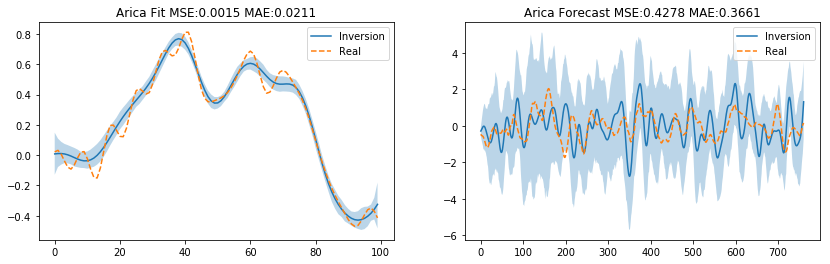

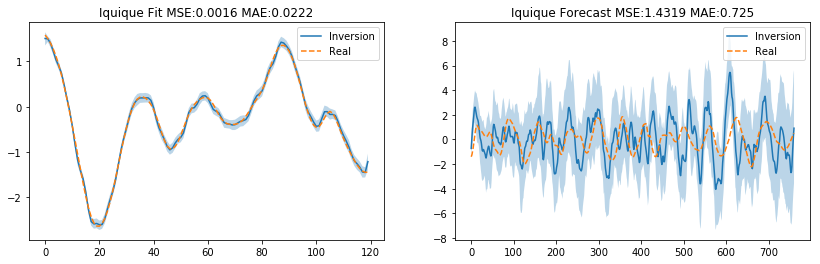

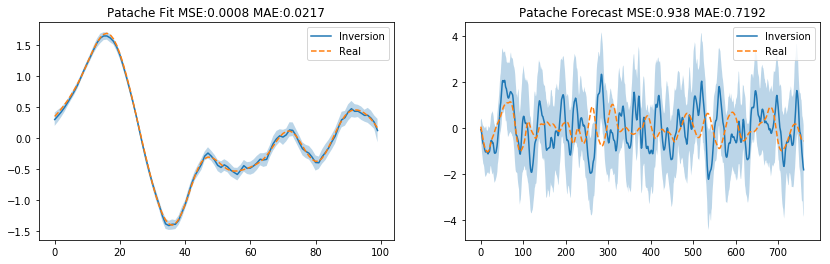

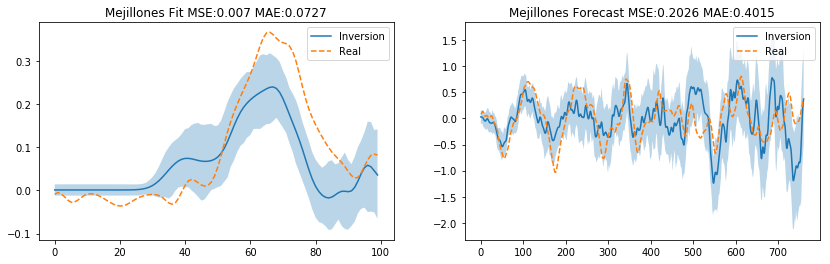

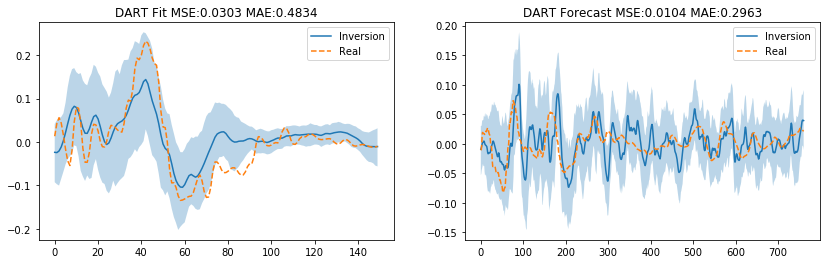

In [250]:
#Plotting solutions with ELM 
for A_train_i, b_train_i,A_test_i, b_test_i,title in zip(AA_train,bb_train,AA_test,bb_test,sensors):
    
    #Creating array to store predictions
    b_preds = []
    b_preds_train = []
    #For each ELM make a new prediction
    for reg in regs:
        if preproc:
            b_pred = preproc_out.inverse_transform(reg.predict(preproc_in.transform(A_test_i)))
            b_pred_train = preproc_out.inverse_transform(reg.predict(preproc_in.transform(A_train_i)))
        else:
            b_pred = reg.predict(A_test_i)
            b_pred_train = reg.predict(A_train_i)
        
        #Storing the predictions
        b_preds.append(b_pred)
        b_preds_train.append(b_pred_train)
        
    #Creating numpy array with predictions
    b_preds = np.array(b_preds)[:,:,0]
    b_preds_train = np.array(b_preds_train)[:,:,0]

    #Calculatin mean prediction
    b_pred_train_mean = np.mean(b_preds_train,axis=0)
    b_pred_mean = np.mean(b_preds,axis=0)    
    
    #Calculating lower and upper percentiles
    #for a 95% confidence the lower interval is at
    #2.5% and the upper is at 97.5%
    train_lower = np.percentile(b_preds_train, 2.5, axis=0)
    train_upper = np.percentile(b_preds_train, 97.5, axis=0)
    test_lower =  np.percentile(b_preds, 2.5, axis=0)
    test_upper =  np.percentile(b_preds, 97.5, axis=0)

    #Calculating metrics for train (inversion) and test (forecast).
    MSE = round(metrics.mean_squared_error(b_test_i[:,0],b_pred_mean)/np.max(b_test_i),4)
    MAE = round(metrics.mean_absolute_error(b_test_i[:,0],b_pred_mean)/np.max(b_test_i),4)
    MSE_train = round(metrics.mean_squared_error(b_train_i[:,0],b_pred_train_mean)/np.max(b_test_i),4)
    MAE_train = round(metrics.mean_absolute_error(b_train_i[:,0],b_pred_train_mean)/np.max(b_test_i),4)
    
    #Plotting all 
    fig,axes = plt.subplots(1,2,figsize=(14,4))
    axes[0].set_title("{} Fit MSE:{} MAE:{}".format(title,MSE_train, MAE_train))
    axes[0].plot(b_pred_train_mean,label="Inversion")
    #Plotting interval train
    axes[0].fill_between(np.arange(len(b_pred_train_mean)),train_lower,train_upper,alpha=0.3)
    axes[0].plot(b_train_i[:,0],"--",label="Real")
    axes[0].legend()
    axes[1].set_title("{} Forecast MSE:{} MAE:{}".format(title,MSE, MAE))
    axes[1].plot(b_pred_mean,label="Inversion")
    #Plotting interval test
    axes[1].fill_between(np.arange(len(b_pred_mean)),test_lower,test_upper,alpha=0.3)
    axes[1].plot(b_test_i[:,0],"--",label="Real")
    axes[1].legend()
    plt.show()

Having $W_{in}$ the ELM input to hidden connection and $W_{out}$ the hidden to output connection with a **Linear** activation function. 

We can calculate the weight propagated for each input with $w = W_{in}W_{out}^T$

In [251]:
ws_list = []
for reg in regs:
    # Win = reg._genelm_regressor.hidden_layer.components_["weights"]
    # Wout = reg.regressor.coef_.T
    ws = reg._genelm_regressor.hidden_layer.components_["weights"]@reg.regressor.coef_.T
    ws_list.append(ws)
ws_list = np.array(ws_list)[:,:,0]

In [260]:
#Calculating mean an variance of the weights
ws_mean = np.mean(ws_list,axis=0)
ws_var = np.std(ws_list,axis=0)**2
#Normalizing variance
ws_var_norm = (ws_var - np.min(ws_var))/ np.max(ws_var)

## Plotting weights
Now we can plot the weights for each source point, the **bigger the point smaller the weight variance**.

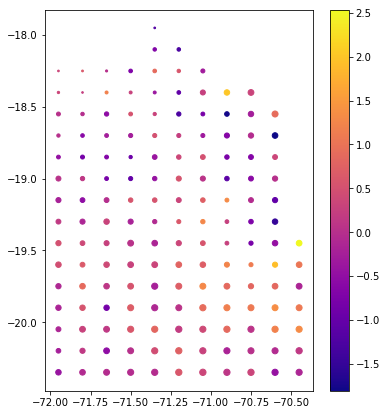

In [273]:
#Source points used
plt.figure(figsize=(6,7))
plt.scatter(u[:,0],u[:,1],c=ws_mean,cmap="plasma",s=(1-ws_var_norm)*40)
plt.colorbar()